In [1]:
import tensorflow as tf
import os
import glob
import pandas as pd
import numpy as np
from progress.bar import Bar
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

# Load data

In [2]:
DATA_DIR = os.getcwd() + '/data'
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3


ground_truth_df = pd.read_csv(DATA_DIR + '/ISIC_2019_Training_GroundTruth.csv')

In [3]:
ground_truth_df.head()

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

There are no `unknown` class examples in the training data. 

In [4]:
ground_truth_df['UNK'].unique()

array([0.])

Get class names

In [5]:
CLASS_NAMES = ground_truth_df.columns.values[1:]
NCLASSES = len(CLASS_NAMES)

In [6]:
CLASS_NAMES

array(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'],
      dtype=object)

Get a column with one hot encoded labels and a column with the class name.

In [7]:
def one_hot(labels):
    return np.array(labels[CLASS_NAMES].values, dtype = np.int32)
    
def dx(labels):
    return CLASS_NAMES[labels['one_hot'] == 1][0]

In [8]:
ground_truth_df['one_hot'] = ground_truth_df.apply(one_hot, axis = 1)
ground_truth_df['dx'] = ground_truth_df.apply(dx, axis = 1)

In [9]:
ground_truth_df.head()

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK  \
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   

                       one_hot   dx  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0]   NV  
1  [0, 1, 0, 0, 0, 0, 0, 0, 0]   NV  
2  [1, 0, 0, 0, 0, 0, 0, 0, 0]  MEL  
3  [0, 1, 0, 0, 0, 0, 0, 0, 0]   NV  
4  [1, 0, 0, 0, 0, 0, 0, 0, 0]  MEL

# Get class weights

In order to deal with the imbalance in the data, we will use class weights.

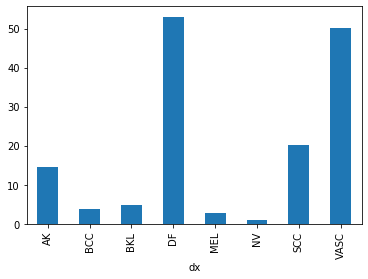

In [10]:
class_weights = 1/ground_truth_df.groupby(by='dx')['dx'].count()*len(ground_truth_df)/2
class_weights.plot.bar()

In [11]:
class_weights_dict = class_weights.to_dict()
class_weights_dict = {key : class_weights_dict[key] for key in CLASS_NAMES[:-1]}
class_weights_dict

{'MEL': 2.8008624502432555,
 'NV': 0.9837281553398058,
 'BCC': 3.8114655431838704,
 'AK': 14.608419838523645,
 'BKL': 4.826791158536586,
 'DF': 52.99372384937238,
 'VASC': 50.06126482213438,
 'SCC': 20.16799363057325}

Turn the class labels into integers to use these weights during training. 

In [12]:
class_weights_dict = {key : class_weights_dict[CLASS_NAMES[key]] for key in range(8)}

In [13]:
class_weights_dict

{0: 2.8008624502432555,
 1: 0.9837281553398058,
 2: 3.8114655431838704,
 3: 14.608419838523645,
 4: 4.826791158536586,
 5: 52.99372384937238,
 6: 50.06126482213438,
 7: 20.16799363057325}

# Explore the images

Let's look at a few images from the training data.

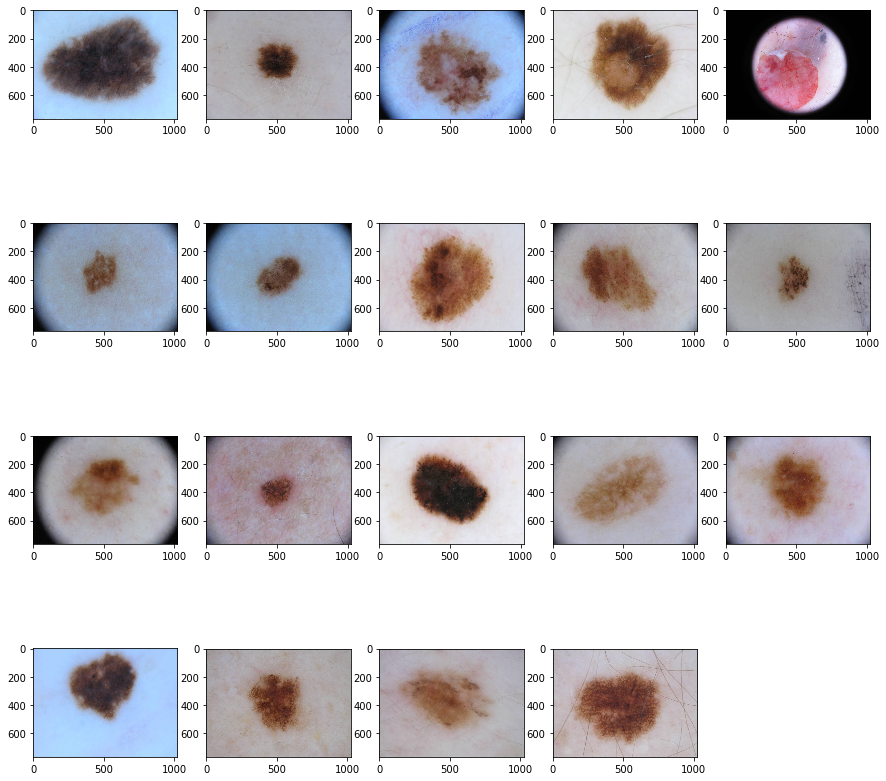

In [40]:
plt.figure(figsize = (15,15))
image_ids = ground_truth_df['image']

for idx, img_id in enumerate(image_ids[:19]):
    file_path = 'data/ISIC_2019_Training_Input/' + img_id + '.jpg'

    img = tf.keras.preprocessing.image.load_img(file_path)
    plt.subplot(4,5,idx+1)
    plt.imshow(img)




As you can see above, possibly due to the image gathering process, some images has a black circular boundary showing up at the corners. To reduce the effect of this we can apply a central crop to all images as shown below. This could be part of preprocessing the data. 

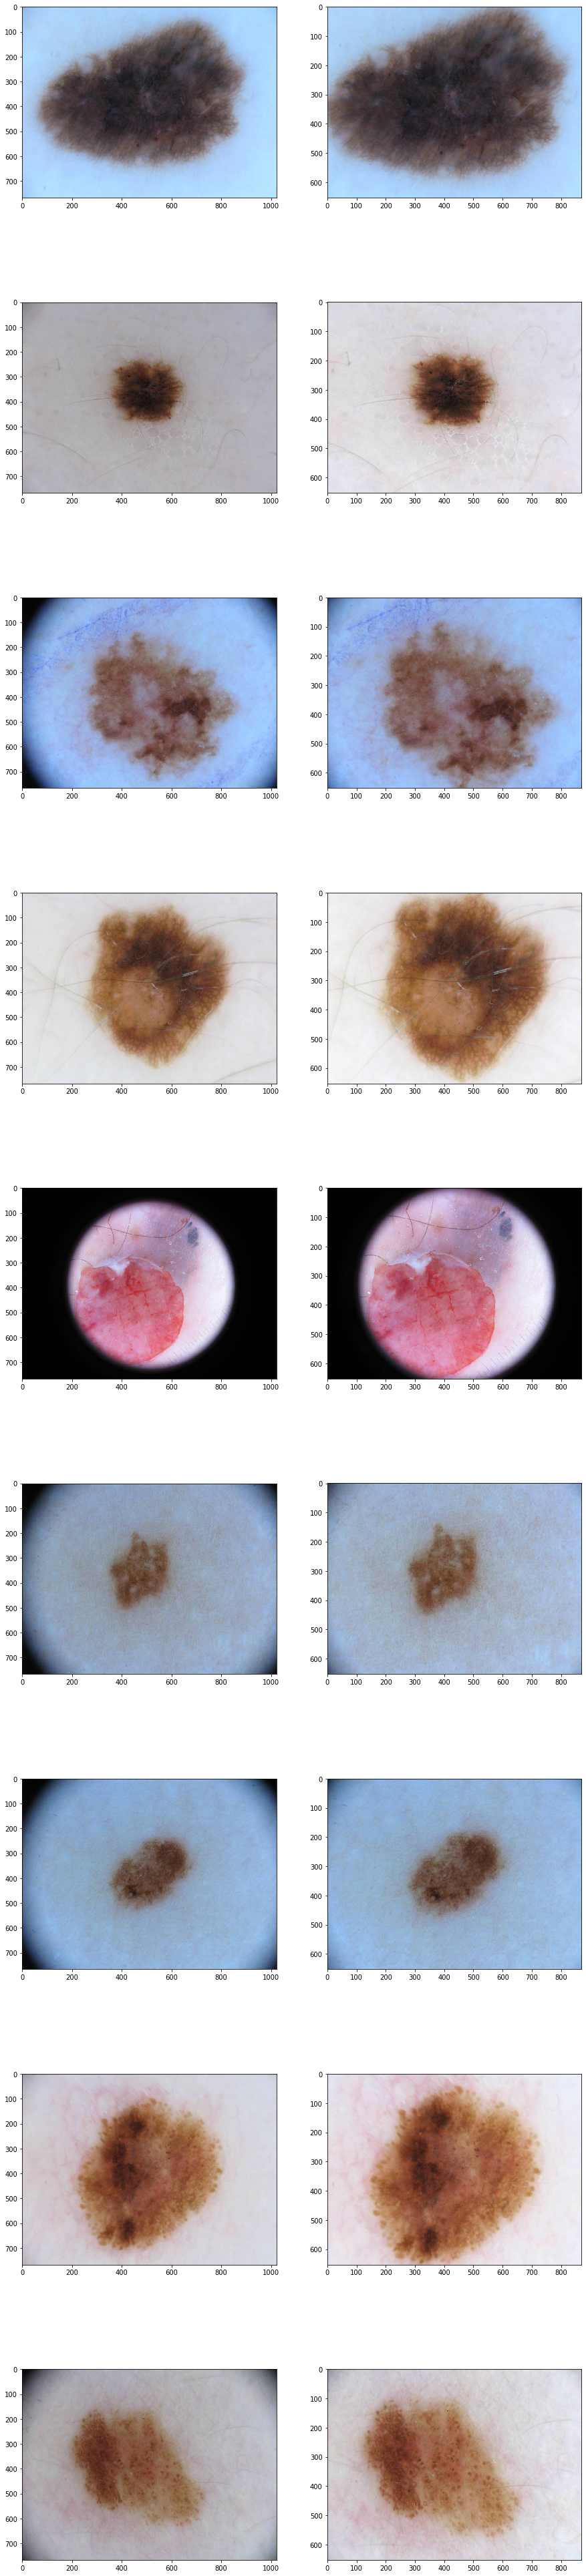

In [50]:
plt.figure(figsize = (15,80))
count = 1
for img_id in image_ids[:9]:
    img = tf.keras.preprocessing.image.load_img('data/ISIC_2019_Training_Input/' + img_id + '.jpg')
    plt.subplot(10,2, count)
    plt.imshow(img)
    
    img_array = tf.keras.preprocessing.image.img_to_array(img) 
    cropped_img_array = tf.image.central_crop(img_array, 0.85)
    cropped_img = tf.keras.preprocessing.image.array_to_img(cropped_img_array)
    plt.subplot(10,2,count+1)
    plt.imshow(cropped_img)
    
    count = count + 2
    


As part of preprocessing we can also adjust the contrast of the images.  

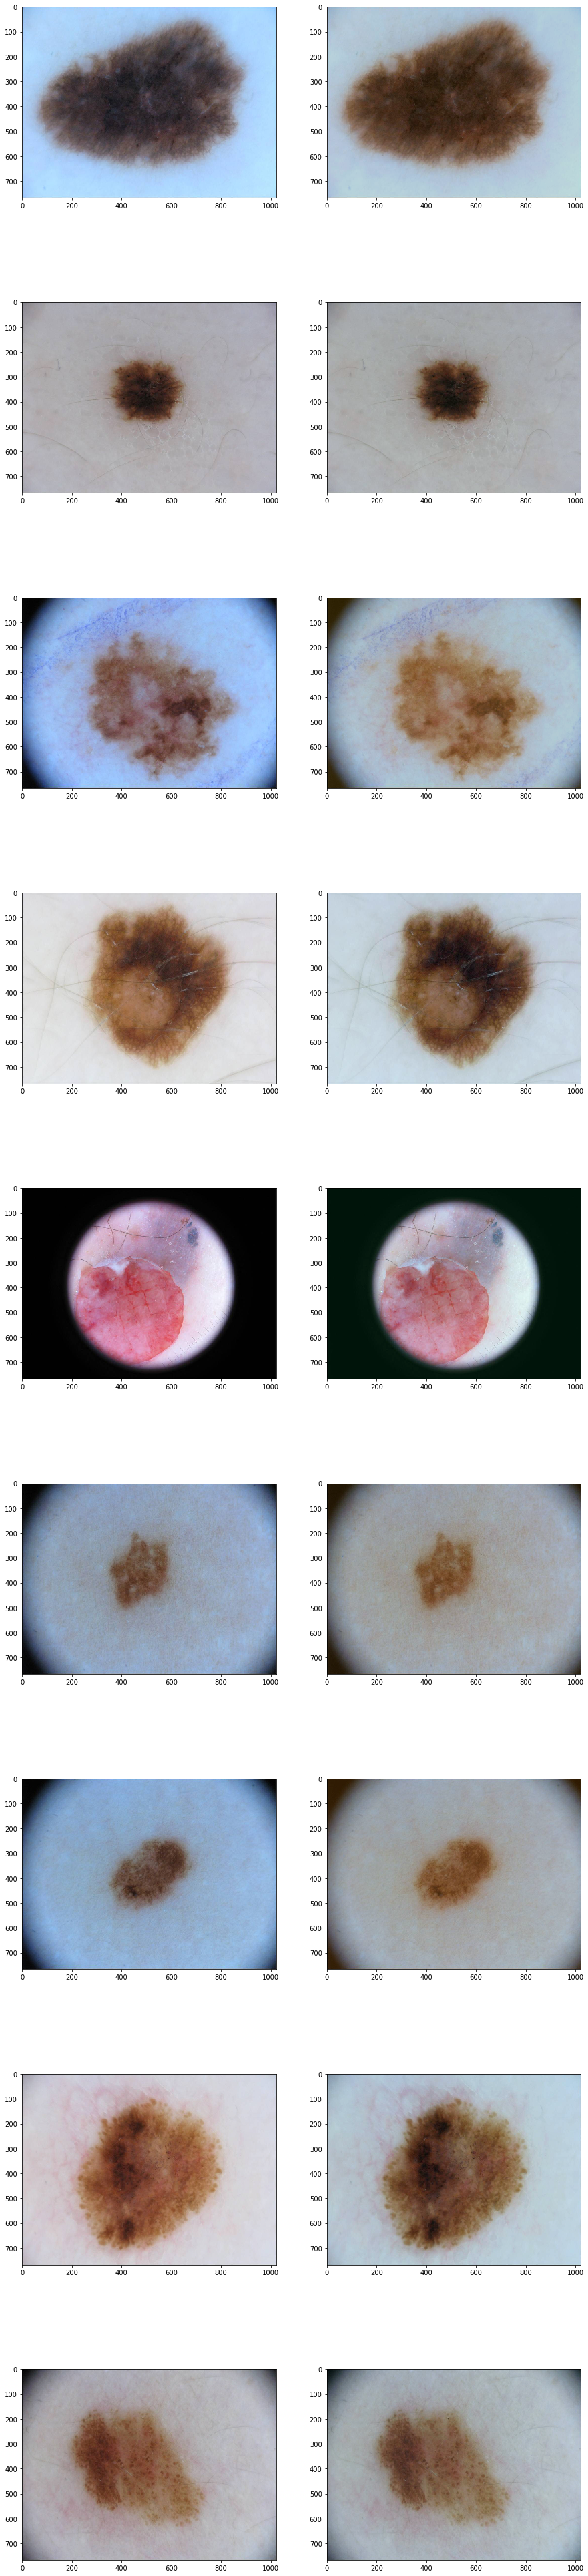

In [65]:
plt.figure(figsize = (15,80))
count = 1
for img_id in image_ids[:9]:
    img = tf.keras.preprocessing.image.load_img('data/ISIC_2019_Training_Input/' + img_id + '.jpg')
    plt.subplot(10,2, count)
    plt.imshow(img)
    
    img_array = tf.keras.preprocessing.image.img_to_array(img) 
    adjusted_img_array = tf.image.adjust_contrast(img_array, 50)
    adjusted_img = tf.keras.preprocessing.image.array_to_img(adjusted_img_array)
    plt.subplot(10,2,count+1)
    plt.imshow(adjusted_img)
    
    count = count + 2


To create our submission we used the original images without these preprocessing steps. An improvement on the model performence may be achieved by applying these preprocessing steps. 